In [ ]:

!pip install contractions
!pip install textsearch
!pip install guidedlda

import sys
print(sys.version)

import guidedlda
import os
import codecs
import unicodedata
import tensorflow as tf
tf.reset_default_graph()
import numpy as np
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import re
import string
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xml.etree.ElementTree as ET
from itertools import chain
import matplotlib.pyplot as plt

nltk.download()  #input d, all, q

In [ ]:
# load your gdrive folder
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# List the content of your gdrive folder 
!ls "gdrive/My Drive/Colab Notebooks/TextProcessing/data/"
data_dir='gdrive/My Drive/Colab Notebooks/TextProcessing/data/'

# zippth="gdrive/My Drive/Colab Notebooks/TextProcessing/en_wiki_word2vec_300.zip"
# from zipfile import ZipFile

	
# # Create a ZipFile Object and load sample.zip in it
# with ZipFile(zippth, 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall(data_dir)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
ABSA_SemEval2014  ABSA_SemEval2016  en_wiki_word2vec_300.txt
ABSA_SemEval2015  checkpoints	    wiki_embedding_mat.npy


In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_number(words):
    """Remove punctuation & number from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'([^\s\w]|_|[0-9])+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

stop_words = set(stopwords.words("english"))
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_number(words)
#     words = remove_stopwords(words)
#    words = stem_words(words)
#    words = lemmatize_verbs(words)
    return words


def create_dic(list_, max_sequence_length, min_word_frequency):
    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length, min_frequency=min_word_frequency) 
    vocab_processor.fit(list_)
    vocab_dict = vocab_processor.vocabulary_._mapping
    sorted_vocab = sorted(vocab_dict.items(), key = lambda x : x[1])
    vocabulary = list(list(zip(*sorted_vocab))[0])
    return vocabulary, vocab_dict, vocab_processor
  
def word2idx_in_dic(list_, vocab_processor):
    text_data_to_transform = [' '.join(word) for word in list_]  
    text_processed = np.array(list(vocab_processor.transform(text_data_to_transform)))
    return text_processed
  
  
def create_doc_term_matrix(list_):
    vec = CountVectorizer()
    X = vec.fit_transform(list_)
    Data = X.toarray()
    return Data,vec
  
def create_doc_term_matrix_v2(list_,vec):
    X = vec.transform(list_)
    Data = X.toarray()
    return Data
  
  
def before(value, a):
    # Find first part and return slice before it.
    pos_a = value.find(a)
    if pos_a == -1: return ""
    return value[0:pos_a]

      

def sortchildrenby(parent, attr):
    parent[:] = sorted(parent, key=lambda child: int(child.get(attr)))
    

def get_data_from_2014(domain, data_dir):
    train_filename = data_dir + domain + '_Train_Final.xml'
    test_filename = data_dir + domain + '_Test.xml'
#    print(test_filename)
    train_data=[]
    test_data=[]
    sentences = ET.parse(train_filename).getroot()
    for i in range(len(sentences)):
        try:
            new_sentence = sentences[i].find('text').text
            new_sentence = word_tokenize(new_sentence)
            new_sentence  = normalize(new_sentence)
            aspectTerms = sentences[i].find('aspectTerms').findall('aspectTerm')

            sortchildrenby(aspectTerms, 'from')
            for opinion in aspectTerms:
                polarity = opinion.get('polarity') 
                term = re.sub(r'[^\w\s]',' ', opinion.get('term').lower()).strip() 
#                print("$$$$$$$$$$$$$$$$$$$$$$$$$$$",term)
                if polarity == 'conflict':
                    continue
                
                sentence = {"domain":domain, "aspect":term, "sentiment":polarity, "text":new_sentence}
#                print("***************************",sentence["text"])
                train_data.append(sentence)
        except AttributeError:
            continue        
                
    sentences = ET.parse(test_filename).getroot()
    for i in range(len(sentences)):
        try:
            new_sentence = sentences[i].find('text').text
            new_sentence = word_tokenize(new_sentence)
            new_sentence  = normalize(new_sentence)
            aspectTerms = sentences[i].find('aspectTerms').findall('aspectTerm')

            sortchildrenby(aspectTerms,'from')
            for opinion in aspectTerms:
                polarity = opinion.get('polarity') 
                term = re.sub(r'[^\w\s]',' ', opinion.get('term').lower()).strip() 
#                print("$$$$$$$$$$$$$$$$$$$$$$$$$$$test",term)
                if polarity == 'conflict':
                    continue
                
                sentence = {"domain":domain, "aspect":term, "sentiment":polarity, "text":new_sentence}
#                print("***************************",sentence["text"])
                test_data.append(sentence)
        except AttributeError:
            continue
    return train_data, test_data
    
    
def get_data_2015_2016(domain, data_dir):
    train_filename = data_dir + domain + '_Train_Final.xml'
    test_filename = data_dir + domain + '_Test.xml'
#    print(test_filename)
    reviews = ET.parse(train_filename).getroot().findall('Review')
    train_data=[]
    test_data=[]
    sentences = []
    for r in reviews:
        sentences += r.find('sentences').getchildren()

    for i in range(len(sentences)):
        try:
            new_sentence = sentences[i].find('text').text
            new_sentence = word_tokenize(new_sentence)
            new_sentence  = normalize(new_sentence)
            opinions = sentences[i].find('Opinions').findall('Opinion')
            sortchildrenby(opinions, 'from')
            for opinion in opinions:
                polarity = opinion.get('polarity')
                target = opinion.get('target').lower()
                sentence = {"domain":domain, "aspect":target, "sentiment":polarity, "text":new_sentence}
#                print("***************************",sentence["text"])
                train_data.append(sentence)
            
        except AttributeError:
                continue
            
    reviews = ET.parse(test_filename).getroot().findall('Review')        
    for r in reviews:
        sentences += r.find('sentences').getchildren()

    for i in range(len(sentences)):
        try:
            new_sentence = sentences[i].find('text').text
            new_sentence = word_tokenize(new_sentence)
            new_sentence  = normalize(new_sentence)
            opinions = sentences[i].find('Opinions').findall('Opinion')
            sortchildrenby(opinions, 'from')
            for opinion in opinions:
                polarity = opinion.get('polarity')
                target = opinion.get('target').lower()
                sentence = {"domain":domain, "aspect":target, "sentiment":polarity, "text":new_sentence}
#                print("***************************test",sentence["text"])
                test_data.append(sentence)
            
        except AttributeError:
                continue 
    return train_data, test_data
    
    
def load_data():
    train_data = []
    test_data = []
    data_dir_2014 = data_dir+'ABSA_SemEval2014/'
    data_dir_2015 = data_dir+'ABSA_SemEval2015/'
    data_dir_2016 = data_dir+'ABSA_SemEval2016/'
    train_r_2014, test_r_2014 = get_data_from_2014('Restaurants', data_dir_2014)    
    train_L_2014, test_L_2014 = get_data_from_2014('Laptops', data_dir_2014)
    train_r_2015,  test_r_2015 = get_data_2015_2016('Restaurants', data_dir_2015)
    train_r_2016,  test_r_2016 = get_data_2015_2016('Restaurants', data_dir_2016)
    train_data = [train_r_2014, train_L_2014, train_r_2015, train_r_2016]
    train_data = list(chain.from_iterable(train_data))
    test_data = [test_r_2014, test_L_2014, test_r_2015, test_r_2016]
    test_data = list(chain.from_iterable(test_data))
    return train_data, test_data

In [ ]:
max_sequence_length = 30
min_word_frequency = 0

seed_topic_list =  [['good', 'excellent', 'superior','nice', 'bad', 'wrong','awful','terrible'],
                    ['food','cuisine', 'appetizer', 'entrees', 'dessert', 'antipasta'],
                    ['bagels', 'toast', 'pastry', 'cake', 'bread', 'bagel'],
                    ['dish', 'plate', 'dishes', 'cup', 'bottle'],
					          ['tables', 'desk', 'dressing', 'design','decoration'],
                    ['drinks', 'seltzer', 'poivre', 'beer', 'beverages', 'mojito', 'beers', 'sangria'],
                    ['atmosphere', 'restaurants', 'environment', 'dining', 'restaurant', 'terrace', 'corridor', 'ambiance', 'room' ],
                    ['sausage', 'chicken', 'meats', 'steak', 'bacon', 'beef', 'sushi', 'rice', 'mussels'],
                    ['martini', 'broth', 'sandwich', 'pizzas', 'pesto', 'pasta','tandoori'],
                    ['lobster', 'crab', 'tuna', 'fish', 'salmon', 'crabmeat', 'tempura', 'seafood'],
                    ['soups','mayonnaise', 'vegatables', 'slaw', 'salads', 'congee', 'porridge', 'noodles']]

seed_topic_list2 = [['good', 'excellent', 'superior','nice', 'bad', 'wrong','awful','terrible'],
                    ['charge', 'battery', 'power', 'charger',  'usb', 'cord', 'powerbook', 'fan', 'techie', 'cool', 'temperatures'],
                    ['screen', 'gui',  'monitor', 'color', 'lcd', 'graphics', 'glass', 'style', 'songs', 'speaking' ],
                    ['hard', 'drive', 'keyboard', 'touchpad', 'driver', 'vga', 'board', 'mouse', 'memory', 'motherboard'],
                    ['netbook', 'macbooks', 'laptops', 'netbooks', 'macbook', 'multitouch', 'laptop', 'imac','notebook', 'ipod'],
                    ['service', 'applications' ,  'program', 'soft', 'software', 'microsoft', 'droid', 'xp', 'pcs','computers', 'mac' ],
                    ['disc', 'drivers', 'devices', 'system',  'tech',  'hardware',  'machine', 'discs', 'speed'],
                    ['customer',  'technician', 'helps',  'assistance', 'documents', 'performace', 'quality', 'support', 'warranty' , 'assurance'],
                    ['webcam',  'backup', 'recovery', 'protection', 'crashes', 'factor', 'computer', 'pc' , 'toshiba', 'intel', 'windows' ],
                    ['price', 'card', 'credit', 'buy', 'shop', 'money'],
                    ['features', 'bluetooth', 'games', 'ichat', 'clock', 'bios', 'snap', 'vmware', 'appleworks']]



train_data , test_data = load_data()
                    
Data = []
for i in range (len(train_data)):  
    Data.append(train_data[i]["text"])
    
for i in range (len(test_data)):  
    Data.append(test_data[i]["text"])

print(Data)

Data = list(chain.from_iterable(Data))
vocabulary, vocab_dict, vocab_processor = create_dic(Data, max_sequence_length, min_word_frequency)

# Data, vec_CountVectorizer = create_doc_term_matrix(Data)
###
print((vocab_dict))

#--------------------------------------------------------------------------------------------
new_Data = train_data + test_data
print(len(new_Data))
new_Data_1 = []  
new_Data_2 = []
for i in range(len(new_Data)):
        domain = new_Data[i]["domain"]
        if domain.lower() == 'laptops':
          new_Data_1.append(new_Data[i])
        else:
          new_Data_2.append(new_Data[i])

          
                    
Data_1 = np.zeros(shape=(len(new_Data_1),len(vocab_dict)), dtype=np.intc)#!!!!!!!!!!!!!!!!!!!!!
Data_2 = np.zeros(shape=(len(new_Data_2),len(vocab_dict)), dtype=np.intc)#!!!!!!!!!!!!!!!!!!!!!       
print(Data_1.shape)
print(Data_2.shape)
                    
for i in range (len(new_Data_1)):    
     text = new_Data_1[i]["text"]
     for word in text :
         Data_1[i,vocab_dict[word]] += 1

for i in range (len(new_Data_2)):    
     text = new_Data_2[i]["text"]
     for word in text :
         Data_2[i,vocab_dict[word]] += 1          

# #--------------------------------------------------------------------------------------------

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
     for word in st:
         seed_topics[vocab_dict[word]] = t_id
        
        
seed_topics2 = {}
for t_id, st in enumerate(seed_topic_list2):
     for word in st:
         seed_topics2[vocab_dict[word]] = t_id
        
        
        
model = guidedlda.GuidedLDA(n_topics=16, n_iter=1000, random_state=7, refresh=20)
model.fit(Data_1, seed_topics=seed_topics, seed_confidence=0.25)
# n_top_words = 2
# topic_word = model.topic_word_
Phi1 = model.components_
model.purge_extra_matrices()

print('*****')
model2 = guidedlda.GuidedLDA(n_topics=16, n_iter=1000, random_state=7, refresh=20)
model2.fit(Data_2, seed_topics=seed_topics2, seed_confidence=0.25)
Phi2 = model2.components_
model2.purge_extra_matrices()

print(Phi1.shape)
print(Phi2.shape)
#for i, topic_dist in enumerate(topic_word):
#        topic_words = np.array(vocabulary)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#        print('Topic {}: {}'.format(i, ' '.join(topic_words))) 

In [ ]:
# from IPython.display import clear_output
# clear_output(wait=True)
vocab_size=len(vocabulary)
embedding_size = 300


# wiki=data_dir+'en_wiki_word2vec_300.txt'
# wiki_embedding_mat=np.random.uniform(low=-0.01, high=0.01, size=[vocab_size, embedding_size])
# with open(wiki, "r") as fin: 
#     x = fin.readline()
#     print(x)
#     k=0
#     while(x):
#       x = fin.readline()
#       y=x.split(' ')      
# #       for idx in range(vocab_size):
#       if vocabulary.count(y[0]) > 0:
#           idx=vocabulary.index(y[0])
#           vec=(np.array(y[1:])).astype(np.float32)
#           wiki_embedding_mat[idx,...]=vec
#           k+=1
#           print(k,'==>',idx,vec.shape)            

# print("wiki_embedding_mat size ==>",wiki_embedding_mat.shape)

# np.save(data_dir+'wiki_embedding_mat',wiki_embedding_mat)


wiki_embedding_mat=np.load(data_dir+'wiki_embedding_mat.npy')
print("wiki_embedding_mat size ==>",wiki_embedding_mat.shape)


wiki_embedding_mat size ==> (7370, 300)


In [ ]:
def feed_forward(x, num_hiddens, activation=None, reuse=False):
    with tf.variable_scope('feed-forward2', reuse=reuse):
        ff = tf.layers.dense(x, num_hiddens, activation=activation, reuse=reuse)
    return ff


def linear(x, num_hiddens=None, reuse=False):
    if num_hiddens is None:
        num_hiddens = x.get_shape().as_list()[-1]
    # with tf.variable_scope('linear'):
    linear_layer = tf.layers.dense(x, num_hiddens)
    return linear_layer


def dropout(x, is_training, rate=0.2):
    return tf.layers.dropout(x, rate, training=tf.convert_to_tensor(is_training))
  
# def regularization(x, is_training, rate=0.2):
#     return tf.layers.dropout(x, rate, training=tf.convert_to_tensor(is_training))

def residual(x_in, x_out, reuse=False):
    with tf.variable_scope('residual', reuse=reuse):
        res_con = x_in + x_out
    return res_con


def normalization(x, eps=1e-8):  # FIXME
    with tf.variable_scope('norm'):
        inputs_shape = x.get_shape()
        params_shape = inputs_shape[-1:]

        mean, variance = tf.nn.moments(x, [-1], keep_dims=True)
        beta = tf.Variable(tf.zeros(params_shape))
        gamma = tf.Variable(tf.ones(params_shape))
        normalized = (x - mean) / tf.sqrt(variance + eps)
        outputs = gamma * normalized + beta

    return outputs


def optimize(loss, learning_rate=0.01):
    return tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(loss)




 
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################


rnn_cells = {
    'GRU': tf.nn.rnn_cell.GRUCell,
    'LSTM': tf.nn.rnn_cell.BasicLSTMCell,
}


def rnn_layer(embedded_x, hidden_size, bidirectional=True, cell_type='LSTM', reuse=False):
    with tf.variable_scope('recurrent', reuse=reuse):
        cell = rnn_cells[cell_type]

        fw_rnn_cell = cell(hidden_size)

        if bidirectional:
            bw_rnn_cell = cell(hidden_size)
            rnn_outputs, _ = tf.nn.bidirectional_dynamic_rnn(fw_rnn_cell,
                                                             bw_rnn_cell,
                                                             embedded_x,
                                                             dtype=tf.float64)
            output = tf.concat([rnn_outputs[0], rnn_outputs[1]], axis=2)
        else:
            output, _ = tf.nn.dynamic_rnn(fw_rnn_cell,
                                          embedded_x,
                                          dtype=tf.float32)
    return output
  
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

def stacked_multihead_attention(U_aspect, U_senti, outputs_rnn, dropout_rate,
                                reuse=False):
    num_hiddens = outputs_rnn.get_shape().as_list()[-1]
    max_len = outputs_rnn.get_shape().as_list()[1]
    with tf.variable_scope('stacked_multihead_attention', reuse=reuse):
               attention_score1 = tf.nn.softmax(tf.contrib.slim.fully_connected(U_aspect, 1))
               attention_score2 = tf.nn.softmax(tf.contrib.slim.fully_connected(U_senti, 1))
               attention_score3 = tf.nn.softmax(tf.contrib.slim.fully_connected(outputs_rnn, 1))
               attention_out1 = tf.squeeze(tf.matmul(tf.transpose(outputs_rnn, perm=[0, 2, 1]), attention_score1),axis=-1)
               attention_out2 = tf.squeeze(tf.matmul(tf.transpose(outputs_rnn, perm=[0, 2, 1]), attention_score2),axis=-1)
               attention_out3 = tf.squeeze(tf.matmul(tf.transpose(outputs_rnn, perm=[0, 2, 1]), attention_score3),axis=-1)
               emb_x = tf.concat([attention_out1 ,attention_out2 ,attention_out3], axis=1)
#               W1 = tf.random_uniform([num_hiddens], -0.01, 0.01,dtype=tf.float64)
#               tmp1 = tf.matmul(tf.reshape(outputs_rnn, [-1, num_hiddens]), tf.reshape(W1, [-1, 1]))
#               M1 = tf.tanh(tmp1)          
#               alpha1 = tf.nn.softmax(tf.reshape(M1,  (-1, max_len)))
#               r1 = tf.matmul(tf.transpose(outputs_rnn, [0, 2, 1]), tf.reshape(alpha1, [-1, max_len, 1]))
#               r1 = tf.squeeze(r1)
#               h_drop1 = tf.nn.dropout(r1, dropout_rate)
              
#               W2 = tf.random_uniform([num_hiddens], -0.01, 0.01,dtype=tf.float64)
#               tmp2 = tf.matmul(tf.reshape(U_senti, [-1, num_hiddens]), tf.reshape(W2, [-1, 1]))
#               M2 = tf.tanh(tmp2)          
#               alpha2 = tf.nn.softmax(tf.reshape(M2,  (-1, max_len)))
#               r2 = tf.matmul(tf.transpose(outputs_rnn, [0, 2, 1]), tf.reshape(alpha2, [-1, max_len, 1]))
#               r2 = tf.squeeze(r2)
#               h_drop2 = tf.nn.dropout(r2, dropout_rate)              

#               W3 = tf.random_uniform([num_hiddens], -0.01, 0.01,dtype=tf.float64)
#               tmp3 = tf.matmul(tf.reshape(U_aspect, [-1, num_hiddens]), tf.reshape(W3, [-1, 1]))
#               M3 = tf.tanh(tmp3)          
#               alpha3 = tf.nn.softmax(tf.reshape(M3,  (-1, max_len)))
#               r3 = tf.matmul(tf.transpose(outputs_rnn, [0, 2, 1]), tf.reshape(alpha3, [-1, max_len, 1]))
#               r3 = tf.squeeze(r3)
#               h_drop3 = tf.nn.dropout(r3, dropout_rate)
#               emb_x = tf.concat([h_drop1 ,h_drop2 ,h_drop3], axis=1)
    return emb_x


   
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################


def MultiheadAttentionBiLSTM(input, hidden_size, U_aspect, U_senti, dropout_rate=0.8, reuse=False):

    cell_type='LSTM'
    outputs_rnn = rnn_layer(input, hidden_size, cell_type)
#     atten_in = tf.concat([outputs_sen, U_aspect, U_senti], 2)
    emb_x = stacked_multihead_attention(U_aspect,U_senti,outputs_rnn,                                         
                                         dropout_rate=dropout_rate,
                                         reuse=reuse)
    
#     atten_out = tf.reduce_sum(atten_out, axis=1)
    return emb_x
    

In [ ]:
# tf.reset_default_graph()
# # # vocab_size=1324#len(vocabulary)
# # # embedding_size = 300
# # # wiki_embedding_mat=np.random.uniform(low=-0.01, high=0.01, size=[vocab_size, embedding_size])
# # # max_sequence_length=50
# # /
# /






#network parameters
hidden_size = 300
dropout_rate = 1- 0.2
regularization_rate = 0.001
batch_size = 64
lambda1 = 0.5
lambda2 = 1 - lambda1
learning_rate = 0.01
# epochs = 100

# reset the graph and make sure the random numbers are always the same
def set_seed(seed=2019):
    tf.set_random_seed(seed)
    np.random.seed(seed)
set_seed()

# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
phi_senti = tf.placeholder(tf.float64, [None, max_sequence_length, 1])
phi_aspect =  tf.placeholder(tf.float64, [None, max_sequence_length, 1])
y_1 = tf.placeholder(tf.int32, [None])
y_2 = tf.placeholder(tf.int32, [None])
dropout_keep_prob = tf.placeholder(tf.float64)
# batch_size_PH = tf.placeholder(tf.int32)

# Create embedding
embedding_mat = tf.Variable(tf.convert_to_tensor(wiki_embedding_mat))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)
print("embedding_mat ==>", embedding_mat)
print("embedding_output ==>", embedding_output)


# Generate network
def new_weights(shape):
    return tf.Variable(tf.random_uniform(shape, -0.01, 0.01,dtype=tf.float64))


def new_biases(length):
    # Equivalent to y intercept
    # Constant value carried over across matrix math
    return tf.Variable(tf.random_uniform([length], -0.01, 0.01))

W_senti = new_weights([tf.to_int32(phi_senti.get_shape().as_list()[-1]), hidden_size*2])
W_aspect = new_weights([tf.to_int32(phi_aspect.get_shape().as_list()[-1]), hidden_size*2])
print("W_sent ==>", W_senti)
print("W_aspect ==>", W_aspect)

U_senti = tf.nn.tanh(tf.matmul(phi_senti, W_senti))
U_aspect = tf.nn.tanh(tf.matmul(phi_aspect, W_aspect))
print("U_senti ==>",U_senti)
print("U_aspect ==>",U_aspect)


emb_x = MultiheadAttentionBiLSTM(embedding_output, hidden_size, U_aspect, U_senti, reuse=False)
print("emb_x ==>",emb_x.get_shape())


V_1 = new_weights([tf.to_int32(emb_x.get_shape().as_list()[-1]), hidden_size])
V_2 = new_weights([hidden_size,2])
print("V_1 ==>", V_1)
print("V_2 ==>", V_2)

F_x = tf.nn.tanh(tf.matmul(emb_x, V_1))
print("F_x ==>", F_x)

drp_Fx = tf.nn.dropout(F_x, dropout_keep_prob)

V2_Fx = tf.matmul(drp_Fx, V_2)
print("V2_Fx ==>", V2_Fx)

r_domain = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=V2_Fx, labels=y_1)
loss_L1 = tf.reduce_mean(r_domain)


r_domain = tf.nn.softmax(V2_Fx)
print("r_domain ==>", r_domain)
r_D_1 = r_domain[: ,0]
print("r_D_1 ==>", r_D_1)
r_D_2 = r_domain[: ,1]
print("r_D_2 ==>", r_D_2)

W_D_1 = new_weights([tf.to_int32(emb_x.get_shape().as_list()[-1]), hidden_size * 6])
W_D_2 = new_weights([tf.to_int32(emb_x.get_shape().as_list()[-1]), hidden_size * 6])
# tmp_W_D_1 = tf.expand_dims(W_D_1, 0)
# tmp_W_D_2 = tf.expand_dims(W_D_2, 0)
# W_D_1_rep = tf.tile(tmp_W_D_1,  [batch_size, 1, 1])
# W_D_2_rep = tf.tile(tmp_W_D_2,  [batch_size, 1, 1])
# print("W_D_1_rep ==>", W_D_1_rep)
# print("W_D_2_rep ==>", W_D_2_rep)

# tmp_r_D_1 = tf.expand_dims(r_D_1,-1)
# tmp_r_D_2 = tf.expand_dims(r_D_2,-1)
# print("tmp_r_D_1 ==>", tmp_r_D_1)
# print("tmp_r_D_2 ==>", tmp_r_D_2)

W_mu_1 = tf.einsum('b,mn->bmn', r_D_1, W_D_1)
W_mu_2 = tf.einsum('b,mn->bmn', r_D_2, W_D_2)
# W_mu_1 = tf.multiply(tmp_r_D_1, W_D_1_rep)
# W_mu_2 = tf.multiply(tmp_r_D_2, W_D_2_rep)
print("W_mu_1 ==>", W_mu_1)
print("W_mu_2 ==>", W_mu_2)

W_mu = tf.add(W_mu_1, W_mu_2)
new_emb_x = (W_mu @ emb_x[..., None])[..., 0]
print("W_mu ==>", W_mu)
print("new_emb_x ==>", new_emb_x)
V_x = tf.nn.tanh(new_emb_x)
print("V_x ==>", V_x)


U_1 = new_weights([tf.to_int32(V_x.get_shape().as_list()[-1]), hidden_size])
U_2 = new_weights([hidden_size,3])
print("U_1 ==>", U_1)
print("U_2 ==>", U_2)

G_x = tf.nn.tanh(tf.matmul(V_x, U_1))
print("G_x ==>", G_x)

drp_Gx = tf.nn.dropout(G_x, dropout_keep_prob)

U2_Gx = tf.matmul(drp_Gx, U_2)
print("U2_Gx ==>", U2_Gx)

y_sentiment = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=U2_Gx, labels=y_2)
loss_L2 = tf.reduce_mean(y_sentiment)

res_senti = tf.nn.softmax(U2_Gx)


loss_joint = (loss_L1 * lambda1)+(loss_L2 * lambda2)

# weight regularization 
vars   = tf.trainable_variables() 
loss_regularization = tf.add_n([ tf.nn.l2_loss(v) for v in vars ]) * regularization_rate


train_domain = optimize(loss_L1+loss_regularization, learning_rate=learning_rate)
train_sentiment = optimize(loss_L2+loss_regularization, learning_rate=learning_rate*10)
train_joint = optimize(loss_joint+loss_regularization, learning_rate=learning_rate*10)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(U2_Gx, 1), tf.cast(y_2, tf.int64)), tf.float32))


In [ ]:
import logging
logger = logging.getLogger('guidedlda')
logger.disabled = True



def get_batch(raw_Data, min_ix, max_ix):
  
    X = []
    p_aspect = []
    p_senti  = []
    Y1 = []
    Y2 = []
    for i in range (min_ix, max_ix):
        Data = []
        Data.append(raw_Data[i]["text"])
        word2vec = word2idx_in_dic(Data,vocab_processor)
        X.append(word2vec[0])

        domain = raw_Data[i]["domain"]
        if domain.lower() == 'laptops':
          Y1.append(0)
          Phi = Phi1
        else:
          Y1.append(1)
          Phi = Phi2
          
        text = raw_Data[i]["text"]

        T = np.zeros(shape=(len(text),16)) 
        for wid, word in enumerate(text):
            T[wid,...] = Phi[...,vocab_dict[word]]
        

        if word2vec.shape[1]>T.shape[0]:
            T = np.pad(T, ((0,(word2vec.shape[1]-T.shape[0])),(0,0)), 'constant')
        else:
            T = T[:word2vec.shape[1],...]
        
        
        p_senti.append (T[:,0])
        
        # new idx
        td = raw_Data[i]
        tmp_txt=td['text']
        tmp_asp=td['aspect']
        tmp_asp=tmp_asp.split(' ')
        if tmp_txt.count(tmp_asp[0]) > 0:
              idx=tmp_txt.index(tmp_asp[0])
              if idx>=word2vec.shape[1]:
                idx=1
              tmp_T = T[idx,:]
              idx = np.argmax(tmp_T)
              p_aspect.append(T[:,idx])
        else:
              p_aspect.append(T[:,1]) 
              
                 
        sentiment = raw_Data[i]["sentiment"]
        if sentiment.lower() == 'negative':
            Y2.append(0)
        else:
            if sentiment.lower() == 'neutral':
              Y2.append(1)
            else:
              Y2.append(2)    
              
    X = np.array(X)
    p_aspect = np.array(p_aspect)
    p_aspect = p_aspect[...,np.newaxis]
    p_senti = np.array(p_senti)    
    p_senti = p_senti[...,np.newaxis]
    Y1 = np.array(Y1)
    Y2 = np.array(Y2)
    return X, p_aspect, p_senti, Y1, Y2  

def acc_calc(sess,tmp_raw_Data, mode=1):
    tmp_batch_size = 64
    tmp_num_batches = int(len(tmp_raw_Data)/tmp_batch_size) + 1
    true_lbl = 0
    tmp_loss = 0
    for i in range(tmp_num_batches):
        # Select train data
        min_ix = i * tmp_batch_size
        max_ix = np.min([len(tmp_raw_Data), ((i+1) * tmp_batch_size)])
        X_d, emb_aspect, emb_senti, Y1, Y2 = get_batch(tmp_raw_Data, min_ix, max_ix)
#         print(emb_senti)
        t_dict = {x_data: X_d, 
                  phi_aspect: emb_aspect,
                  phi_senti: emb_senti,
                  y_1: Y1,
                  y_2: Y2,
                  dropout_keep_prob: 1.00}     
#         print("X_test => ",X_d.shape)
        if mode==1:
            loss_, tmp_lbl_3 = sess.run([loss_L1, res_senti], feed_dict=t_dict)
        if mode==2:
            loss_, tmp_lbl_3 = sess.run([loss_L2, res_senti], feed_dict=t_dict)
        if mode==3:
            loss_, tmp_lbl_3 = sess.run([loss_joint, res_senti], feed_dict=t_dict)
            
            
        tmp_lbl = np.argmax(tmp_lbl_3, axis=1)
#         print("labels",tmp_lbl)
        t_l = np.sum(np.equal(tmp_lbl,Y2))
        true_lbl += t_l
        tmp_loss += loss_
        
    acc = true_lbl/len(tmp_raw_Data)
    los = tmp_loss/tmp_num_batches    
    return los, acc
  
# Start a graph and initialize variables  
sess = tf.Session()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess.run(init)

Epoch: 7, Test Loss: 0.081, Test Acc: 0.23
Epoch: 7, Test Loss: 0.081, Test Acc: 0.23
Epoch: 8, Train Loss: 0.087, Train Acc: 0.22
Epoch: 8, Train Loss: 0.087, Train Acc: 0.22
Epoch: 8, Test Loss: 0.08, Test Acc: 0.23
Epoch: 8, Test Loss: 0.08, Test Acc: 0.23
Epoch: 9, Train Loss: 0.081, Train Acc: 0.22
Epoch: 9, Train Loss: 0.081, Train Acc: 0.22
Epoch: 9, Test Loss: 0.073, Test Acc: 0.23
Epoch: 9, Test Loss: 0.073, Test Acc: 0.23
Epoch: 10, Train Loss: 0.077, Train Acc: 0.22
Epoch: 10, Train Loss: 0.077, Train Acc: 0.22
Epoch: 10, Test Loss: 0.075, Test Acc: 0.23
Epoch: 10, Test Loss: 0.075, Test Acc: 0.23
Epoch: 11, Train Loss: 0.074, Train Acc: 0.22
Epoch: 11, Train Loss: 0.074, Train Acc: 0.22
Epoch: 11, Test Loss: 0.068, Test Acc: 0.23
Epoch: 11, Test Loss: 0.068, Test Acc: 0.23
Epoch: 12, Train Loss: 0.07, Train Acc: 0.22
Epoch: 12, Train Loss: 0.07, Train Acc: 0.22
Epoch: 12, Test Loss: 0.069, Test Acc: 0.23
Epoch: 12, Test Loss: 0.069, Test Acc: 0.23
Epoch: 13, Train Loss: 0.0

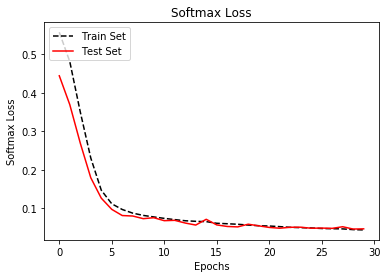

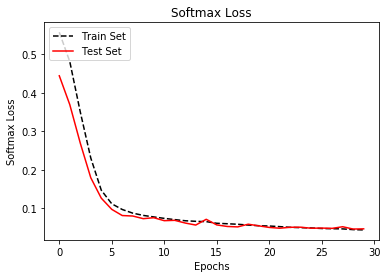

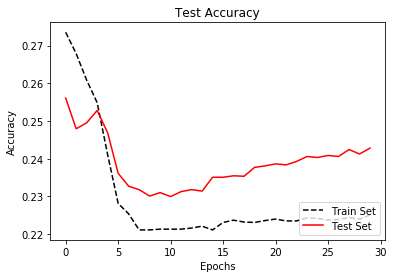

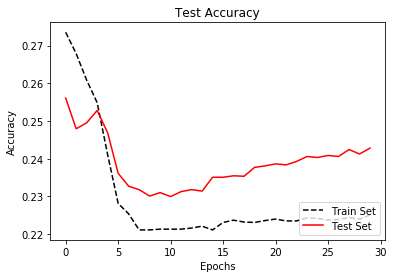

In [ ]:
# shuffled_ix = np.random.permutation(np.arange(len(test_data)))
# test_data = [test_data[j] for j in shuffled_ix]
  
# X_d, emb_aspect, emb_senti, Y1, Y2 = get_batch(test_data, 0, 64)
# print("X_test => ",X_d.shape) 

# test_dict = {x_data: X_d, 
#               phi_aspect: emb_aspect,
#               phi_senti: emb_senti,
#               y_1: Y1,
#               y_2: Y2,
#               dropout_keep_prob: 1.00}
# # print("emb_aspect => ",emb_aspect.dtype)
# # print("emb_senti => ",emb_senti.dtype)
# # print("Y1 => ",Y1.shape)
# # print("Y2 => ",Y2.shape)


train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Start training
for epoch in range(30):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(train_data)))
    train_data = [train_data[j] for j in shuffled_ix]
    num_batches = int(len(train_data)/batch_size)
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(train_data), ((i+1) * batch_size)])
        X_d, emb_aspect, emb_senti, Y1, Y2 = get_batch(train_data, min_ix, max_ix)
        
        #Run train step     
        train_dict = {x_data: X_d, 
                      phi_aspect: emb_aspect,
                      phi_senti: emb_senti,
                      y_1: Y1,
                      y_2: Y2,
                      dropout_keep_prob: 0.80}
        sess.run(train_domain, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = acc_calc(sess,train_data, mode=1)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    print('Epoch: {}, Train Loss: {:.2}, Train Acc: {:.2}'.format(epoch+1, temp_train_loss, temp_train_acc))
    
    
    temp_test_loss, temp_test_acc = acc_calc(sess,test_data, mode=1)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))    
    
save_path = saver.save(sess, data_dir+"/checkpoints/model1_domain.ckpt")
print("Model saved in path: %s" % save_path)
    
# %matplotlib inline

# Plot loss over time
epoch_seq = np.arange(0, epoch+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()




# # Data = [['but', 'the', '*_8_9','staff', 'was', 'so', 'horrible', 'to', 'us']]
# # print (Data)
# # DataT = list(chain.from_iterable(Data))
# # DataT = create_doc_term_matrix_v2(DataT,vec_CountVectorizer)
# # T=model.transform(DataT)
# # print(T.shape)
# # Z=word2idx_in_dic(Data,vocab_processor)
# # print(Z.shape)





In [ ]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Start training
for epoch in range(200):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(train_data)))
    train_data = [train_data[j] for j in shuffled_ix]
    num_batches = int(len(train_data)/batch_size)
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(train_data), ((i+1) * batch_size)])
        X_d, emb_aspect, emb_senti, Y1, Y2 = get_batch(train_data, min_ix, max_ix)
        
        #Run train step     
        train_dict = {x_data: X_d, 
                      phi_aspect: emb_aspect,
                      phi_senti: emb_senti,
                      y_1: Y1,
                      y_2: Y2,
                      dropout_keep_prob: 0.80}
        sess.run(train_sentiment, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = acc_calc(sess,train_data, mode=2)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    print('Epoch: {}, Train Loss: {:.2}, Train Acc: {:.2}'.format(epoch+1, temp_train_loss, temp_train_acc))
    
    
    temp_test_loss, temp_test_acc = acc_calc(sess,test_data, mode=2)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))    
        
    
save_path = saver.save(sess, data_dir+"/checkpoints/model2_sentiment.ckpt")
print("Model saved in path: %s" % save_path)


# %matplotlib inline

# Plot loss over time
epoch_seq = np.arange(0, epoch+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



Epoch: 1, Train Loss: 0.84, Train Acc: 0.63
Epoch: 1, Test Loss: 0.77, Test Acc: 0.67
Epoch: 2, Train Loss: 0.75, Train Acc: 0.69
Epoch: 2, Test Loss: 0.67, Test Acc: 0.72
Epoch: 3, Train Loss: 0.78, Train Acc: 0.68
Epoch: 3, Test Loss: 0.69, Test Acc: 0.72
Epoch: 4, Train Loss: 0.66, Train Acc: 0.73
Epoch: 4, Test Loss: 0.59, Test Acc: 0.77
Epoch: 5, Train Loss: 0.64, Train Acc: 0.75
Epoch: 5, Test Loss: 0.57, Test Acc: 0.78
Epoch: 6, Train Loss: 0.62, Train Acc: 0.75
Epoch: 6, Test Loss: 0.56, Test Acc: 0.78
Epoch: 7, Train Loss: 0.6, Train Acc: 0.76
Epoch: 7, Test Loss: 0.54, Test Acc: 0.79
Epoch: 8, Train Loss: 0.58, Train Acc: 0.77
Epoch: 8, Test Loss: 0.53, Test Acc: 0.8
Epoch: 9, Train Loss: 0.57, Train Acc: 0.77
Epoch: 9, Test Loss: 0.52, Test Acc: 0.8
Epoch: 10, Train Loss: 0.56, Train Acc: 0.78
Epoch: 10, Test Loss: 0.52, Test Acc: 0.8
Epoch: 11, Train Loss: 0.55, Train Acc: 0.78
Epoch: 11, Test Loss: 0.51, Test Acc: 0.8
Epoch: 12, Train Loss: 0.56, Train Acc: 0.78
Epoch: 12,

KeyboardInterrupt: ignored

In [ ]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# Start training
for epoch in range(50):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(train_data)))
    train_data = [train_data[j] for j in shuffled_ix]
    num_batches = int(len(train_data)/batch_size)
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(train_data), ((i+1) * batch_size)])
        X_d, emb_aspect, emb_senti, Y1, Y2 = get_batch(train_data, min_ix, max_ix)
        
        #Run train step     
        train_dict = {x_data: X_d, 
                      phi_aspect: emb_aspect,
                      phi_senti: emb_senti,
                      y_1: Y1,
                      y_2: Y2,
                      dropout_keep_prob: 0.80}
        sess.run(train_joint, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = acc_calc(sess,train_data, mode=3)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    print('Epoch: {}, Train Loss: {:.2}, Train Acc: {:.2}'.format(epoch+1, temp_train_loss, temp_train_acc))
    
    
    temp_test_loss, temp_test_acc = acc_calc(sess,test_data, mode=3)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))    
        
    
save_path = saver.save(sess, data_dir+"/checkpoints/model3_joint.ckpt")
print("Model saved in path: %s" % save_path)


# %matplotlib inline

# Plot loss over time
epoch_seq = np.arange(0, epoch+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

